# Exploratory and statistic indsights

In [1]:
# Load data and refine it a bit (string to datetime, merge both mechanical and electrical, check for null values, ...)

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt


column_names = ['date','capacity','available_mechanical','available_electrical','station_name','station_geo','operative']
df = pd.read_csv('data/historique_stations.csv', header=None, names=column_names)

df['available'] = df['available_mechanical'] + df['available_electrical']
df = df.drop(columns = ['available_mechanical', 'available_electrical'])
df['date'] = pd.to_datetime(df['date'])

print(df.isnull().values.any())
display(df)
df.dtypes

# Trim every string in dataframe because whitespace will become annoying after pivot

trim_strings = lambda x: x.strip() if isinstance(x, str) else x
df = df.applymap(trim_strings)

False


,date,capacity,station_name,station_geo,operative,available
0,2020-11-26 12:59:00+00:00,35,Benjamin Godard - Victor Hugo,"48.86598,2.27572",True,9
1,2020-11-26 12:59:00+00:00,55,André Mazet - Saint-André des Arts,"48.85376,2.33910",True,27
2,2020-11-26 12:59:00+00:00,20,Charonne - Robert et Sonia Delauney,"48.85591,2.39257",True,0
3,2020-11-26 12:59:00+00:00,21,Toudouze - Clauzel,"48.87930,2.33736",True,1
4,2020-11-26 12:59:00+00:00,30,Mairie du 12ème,"48.84086,2.38755",True,4
...,...,...,...,...,...,...
10986725,2021-04-09 14:37:00+00:00,38,Général Michel Bizot - Claude Decaen,"48.83481,2.40093",True,6
10986726,2021-04-09 14:37:00+00:00,20,Ivry - Baudricourt,"48.82470,2.36311",True,3
10986727,2021-04-09 14:37:00+00:00,39,Saint-Mandé - Docteur Arnold Netter,"48.84463,2.40495",True,17
10986728,2021-04-09 14:37:00+00:00,21,Saint-Marcel - Hôpital,"48.83950,2.36099",True,16


## How many stations, total capacity (the highest and the lowest)

In [2]:
num_stations = len(df['station_name'].unique())
highest_capacity = df.sort_values('capacity',ascending=False).groupby(by='station_name').first()['capacity'].sum()
lowest_capacity = df.sort_values('capacity').groupby(by='station_name').first()['capacity'].sum()

print('Number of stations :')
print(num_stations)

print('Highest total capacity :')
print(highest_capacity)

print('Lowest total capacity :')
print(lowest_capacity)


Number of stations :
1396
Highest total capacity :
43982
Lowest total capacity :
43737


## Should we ignore stations ? Check for unresponsive stations, capacity = 0...

### How many total dates are available ? Is is the case for every stations ?

In [3]:
date_arr1 = df['date'].unique()
num_date = len(date_arr1)
latest = date_arr1.max()

print("Number of different dates :")
print(num_date)
print("Latest date :")
print(latest)

Number of different dates :
7866
Latest date :
2021-04-09 14:37:00+00:00


### Check for unresponsive stations

#### Too few data

In [4]:
# Display station when more than half values are missing

stations_groupdf = df.groupby(by='station_name')

val_per_stations_df = stations_groupdf['date'].nunique().sort_values()
too_few_val_per_stations_df = val_per_stations_df[val_per_stations_df < num_date/2]
display(too_few_val_per_stations_df)

station_name
Jean Jaurès - Paul Lafargue        2
station formation alfortville      5
Parmentier - Abel rabaud         612
Arago - Paul Lafargue            680
Name: date, dtype: int64

#### Latest response too old

In [5]:
# Display station when delay is more than an hour

latest_df = latest - stations_groupdf['date'].max()

display(latest_df[latest_df > np.timedelta64(1, 'h')])

station_name
Parmentier - Abel rabaud        126 days 21:36:00
station formation alfortville    30 days 22:05:00
Name: date, dtype: timedelta64[ns]

In [6]:
# We will ignore the stations with too few data

df = df[~df['station_name'].isin(too_few_val_per_stations_df.index)]

### Capacity of 0 (probably bugs) : 

In [7]:
no_cap_df = df[df['capacity'] == 0].groupby('station_name')
display(no_cap_df.size().sort_values())

station_name
Hôpital Européen Georges Pompidou          2
Chabanais - Petits Champs               1154
Université Paris Dauphine               3884
Parc Floral du Bel Air                  3978
Berthier - Porte de Clichy              7866
Champs de Manoeuvre - Cartoucherie      7866
Longchamp - Suresnes                    7866
Quai de la Gare - Pont de Bercy         7866
Saint-Michel - Luxembourg               7866
Verdun - Pierre et Marie Curie          7866
Victor Massé - Jean-Baptiste Pigalle    7866
dtype: int64

### Capacity of 0 but with bikes available (definitely bugs) :

In [8]:
display(df[(df['capacity'] == 0) & (df['available'] > 0)].groupby('station_name').size().sort_values())

station_name
Chabanais - Petits Champs    31
dtype: int64

## Date continuity analysis 

[Timedelta('3 days 19:46:00'), Timedelta('0 days 03:41:00'), Timedelta('0 days 03:24:00'), Timedelta('0 days 02:15:00'), Timedelta('0 days 02:05:00')]
[Timedelta('0 days 00:01:00'), Timedelta('0 days 00:01:00'), Timedelta('0 days 00:01:00'), Timedelta('0 days 00:03:00'), Timedelta('0 days 00:03:00')]
0 days 00:24:32.788302606


[]

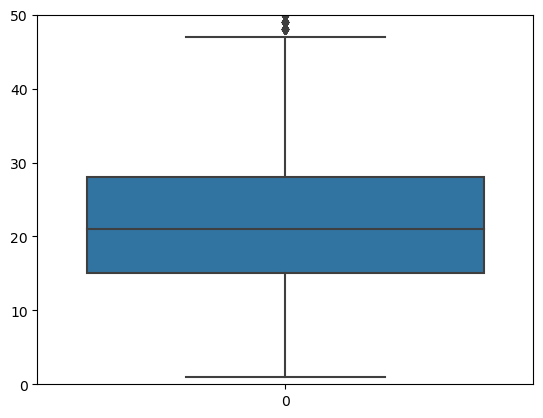

In [9]:
# Can't .diff() a DatetimeArray so do it manually. Remove the first one (and last to get matching lengths), then substract.
import seaborn as sns

date_arr2 = date_arr1[:-1]
date_arr1 = date_arr1[1:]
granularity = date_arr1 - date_arr2
print(sorted(granularity, reverse = True)[:5])
print(sorted(granularity)[:5])
print(granularity.mean())

minutes_gran = [x.total_seconds()/60 for x in granularity]

sns.boxplot(minutes_gran)
plt.ylim(0, 50)
plt.plot()

# Time granularity is uneven, we should resample and pivot the table to have a timeseries dataframe
# We will identify the hole in the data in the following steps


## Setting up the main timeseries and dataframes

In [ ]:
# No duplicate date for each stations so the aggfunc doesn't matter a lot 

available_ts_df = pd.pivot_table(df, index='date', columns='station_name', values='available', aggfunc='first')
operative_ts_df = pd.pivot_table(df, index='date', columns='station_name', values='operative', aggfunc='first')

#Resample to 30 minutes since it covers most of the deltas

available_ts_df = available_ts_df.resample('30T').min()
operative_ts_df = operative_ts_df.resample('30T').min()

# Create a geodataframe for station proximity

info_df = df.groupby(by='station_name')['station_geo'].first().str.split(',', expand=True).astype(float)
info_df.columns = ['lat', 'lon']
cap_df = df.groupby(by='station_name')['capacity'].max()

info_df = info_df.join(cap_df)

#### Displaying a few data

In [ ]:
from random import randint

def disp(df, num):
    rand = [randint(0, len(df.columns)-1) for i in range(num)]
    
    for i in rand:
        col = df.columns[i]
        current_df = pd.DataFrame()
        current_df[df.columns[i]] = df[col]
        current_df.index = df.index
        
        current_df.plot(figsize=(20, 10))
        plt.title(col)
        plt.show()
        
        current_df['hour'] = df.index.hour
        current_df['dayofweek'] = df.index.dayofweek
        
        sns.boxplot(data = current_df, x = 'hour', y = col)
        plt.show()
        sns.boxplot(data = current_df, x = 'dayofweek', y = col)
        plt.show()

disp(available_ts_df, 10)

Some stations experiment seasonality (daily and weekly) and some don't. We consider the visual inspection to be enough and won't do a periodogram.

### Now identifying holes in the data 

In [ ]:
# Randomly select stations and find where are the holes in it

def find_consec_nulls(df, num):
    rand = [randint(0, len(df.columns)-1) for i in range(num)]

    for i in rand:
        col = df.columns[i]
        current_df = df[col]
        display(current_df.isnull().astype(int).groupby(current_df.notnull().astype(int).cumsum()).sum().sort_values())
        
find_consec_nulls(available_ts_df, 5)

2777th index and the 183 following rows should be avoided. Other smaller holes will be filled with previous values so we can carry on.

In [ ]:
available_ts_df = available_ts_df.fillna(method='ffill')
operative_ts_df = operative_ts_df.fillna(method='ffill')

disp(available_ts_df, 3)

### Compute the distance between every stations to get an idea of the "neighbourness"

In [ ]:
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from geopy import distance

coordinates = info_df[['lat','lon']].astype(float).values

coordinates_array = np.array(coordinates)

dist_array = pdist(coordinates_array, lambda u, v: distance.distance(u, v).km)
dist_matrix = squareform(dist_array)

print(dist_matrix)


In [ ]:
dist_df = pd.DataFrame(dist_matrix, index = available_ts_df.columns, columns=available_ts_df.columns)
dist_df.replace(0, np.nan, inplace=True)

In [ ]:
neighbours = {}
close_neighbours = {}

for col in dist_df.columns:
    close_neighbours[col] = dist_df[col][dist_df[col] < 0.5].index.values
    neighbours[col] = dist_df[col][dist_df[col] < 5].index.values


### Get the "activeness" of the stations

In [ ]:
info_df['mean'] = (available_ts_df.diff().abs().mean()).T

display(info_df)

## Creating our datasets

In [ ]:
from tqdm import tqdm

adf1 = available_ts_df[:2777]
adf2 = available_ts_df[2777+183:]

# Get info about close neighbours stations and further located stations to have an idea of the number of circulating bike
def get_info(col):
    c_neighbours = close_neighbours[col]
    a_neighbours = neighbours[col]
    infos = info_df.loc[col].to_dict()
    c_num = c_neighbours.size
    if c_num> 0:
        infos['c_cap'] = info_df[info_df.index.isin(c_neighbours)]['capacity'].sum()
    else:
        infos['c_cap'] = 0
    infos['a_cap'] = info_df[info_df.index.isin(a_neighbours)]['capacity'].sum()
    infos['c_num'] = c_num
    infos['a_neighbours'] = a_neighbours
    infos['c_neighbours'] = c_neighbours
    return infos
    
# Pretty ineficient way to create our dataset
# TODO : make it faster and more elegant
def create_individual(value, date, infos, df):
    c_available = 0
    c_num = 0
    if infos['c_cap'] > 0:
        c_available = infos['c_cap'] - df.loc[date][infos['c_neighbours']].sum()
    a_available = infos['a_cap'] - df.loc[date][infos['a_neighbours']].sum()
    indiv = list(infos.values())[:-2]
    indiv.append(c_available)
    indiv.append(a_available)
    return indiv
    
        
def create_dataset(df, offset):
    X = []
    Y = []
    columns = df.columns
    num_bar = len(columns) * len(df)-336-offset
    with tqdm(total=num_bar) as pbar:
        for col in columns:
            infos = get_info(col)
            serie = df[col]
            dates = serie.index
            # start the range at 336 so we can get the value of the preceeding week
            for i in range(336, len(dates) - offset):
                x = create_individual(serie[i], dates[i], infos, df)
                x.append(serie[i-336+offset])
                x.append(serie[i-48+offset])
                X.append(x)
                Y.append(serie[i+offset])
                pbar.update(1)
    return X, Y

X1, Y1 = create_dataset(adf1, 1)
X2, Y2 = create_dataset(adf2, 1)

X = X1 + X2
Y = Y1 + Y1


# Save the datasets because current version of code takes a lot of time

X_data = np.array(X)
Y_data = np.array(Y)

X_file_path = 'dataset_X.npy'
Y_file_path = 'dataset_Y.npy'

np.save(X_file_path, X_data)
np.save(Y_file_path, Y_data)

### We chose XGboost as our first model.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_

best_xgb_model = xgb.XGBClassifier(**best_params)

# Train the model on the entire training data and then save it
best_xgb_model.fit(X_train, Y_train)

current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f'models/best_xgb_model_{current_date}.joblib'

# Save the best model to a file using joblib
joblib.dump(best_xgb_model, model_filename)

### Model evaluation

In [ ]:
loaded_model = joblib.load(model_filename)
Y_pred = loaded_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classification_rep = classification_report(Y_test, Y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)